# Working on ExperimentLoader

The `ExperimentLoader` class is designed to help with managing the output from a trained MultiomicTransformer model run. It can handle loading and running the trained model, creating plots, calculating AUROC and AUPRC compared to ground truth datasets, and more!

This tutorial will show you how to use the `ExperimentLoader`.

In [1]:
import sys, json, os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
SRC_DIR = str(Path(PROJECT_DIR) / "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import multiomic_transformer.utils.experiment_loader as experiment_loader

GROUND_TRUTH_DIR = Path("data/ground_truth_files")

## Load Model

In [2]:
from importlib import reload

reload(experiment_loader)

<module 'multiomic_transformer.utils.experiment_loader' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py'>

In [2]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="K562_small_model_long_training",
    model_num=2,
)

exp.load_trained_model("trained_model.pt")

## Pre-load Ground Truth DataFrames

In [10]:
def load_ground_truth(ground_truth_file):
    if type(ground_truth_file) == str:
        ground_truth_file = Path(ground_truth_file)
        
    if ground_truth_file.suffix == ".csv":
        sep = ","
    elif ground_truth_file.suffix == ".tsv":
        sep="\t"
        
    ground_truth_df = pd.read_csv(ground_truth_file, sep=sep, on_bad_lines="skip", engine="python")
    
    if "chip" in ground_truth_file.name and "atlas" in ground_truth_file.name:
        ground_truth_df = ground_truth_df[["source_id", "target_id"]]

    if ground_truth_df.columns[0] != "Source" or ground_truth_df.columns[1] != "Target":
        ground_truth_df = ground_truth_df.rename(columns={ground_truth_df.columns[0]: "Source", ground_truth_df.columns[1]: "Target"})
    ground_truth_df["Source"] = ground_truth_df["Source"].astype(str).str.upper()
    ground_truth_df["Target"] = ground_truth_df["Target"].astype(str).str.upper()
    
    # Build TF, TG, and edge sets for quick lookup later
    gt = ground_truth_df[["Source", "Target"]].dropna()

    gt_tfs = set(gt["Source"].unique())
    gt_tgs = set(gt["Target"].unique())
    
    gt_pairs = (gt["Source"] + "\t" + gt["Target"]).drop_duplicates()
    
    gt_lookup = (gt_tfs, gt_tgs, set(gt_pairs))
        
    return ground_truth_df, gt_lookup

gt_by_dataset_dict = {
    "Macrophage": {
        "RN204": load_ground_truth(GROUND_TRUTH_DIR / "rn204_macrophage_human_chipseq.tsv"),
        "ChIP-Atlas macrophage": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_macrophage.csv"),
    },
    "mESC": {
        "ChIP-Atlas mESC": load_ground_truth(GROUND_TRUTH_DIR / "chip_atlas_tf_peak_tg_dist.csv"),
        "RN111": load_ground_truth(GROUND_TRUTH_DIR / "RN111.tsv"),
        "RN112": load_ground_truth(GROUND_TRUTH_DIR / "RN112.tsv"),
        "RN114": load_ground_truth(GROUND_TRUTH_DIR / "RN114.tsv"),
        "RN116": load_ground_truth(GROUND_TRUTH_DIR / "RN116.tsv"),        
    },
    "K562": {
        "ChIP-Atlas K562": load_ground_truth(GROUND_TRUTH_DIR / "chipatlas_K562.csv"),
        "RN117": load_ground_truth(GROUND_TRUTH_DIR / "RN117.tsv"),        
    }
}

## Show Model Settings and Training Parameters

In [ ]:
experiment_settings = exp.experiment_settings_df
experiment_settings

,parameter,value
0,EXPERIMENT_NAME,E7.5_rep1_hvg_filter_disp_0.6
1,DATASET_NAME,mESC_E7.5_rep1_hvg_filter_disp_0.6
2,ORGANISM_CODE,mm10
3,CHROM_ID,NaN
4,SAMPLE_NAMES,E7.5_rep1
...,...,...
60,SHORTCUT_TOPK,NaN
61,SHORTCUT_DROPOUT,0.0
62,SUBSAMPLE_SEED,42
63,ALLOWED_SAMPLES,NaN


In [ ]:
model_training_param_df = pd.DataFrame.from_dict(exp.model_training_params, orient="index", columns=["Value"])
model_training_param_df

,Value
allowed_samples,None
epochs,250
batch_size,16
grad_accum_steps,1
use_grad_accum,True
use_grad_ckpt,True
d_model,128
num_heads,4
num_layers,3
d_ff,512


## Plot the Training Figures

### GPU Usage

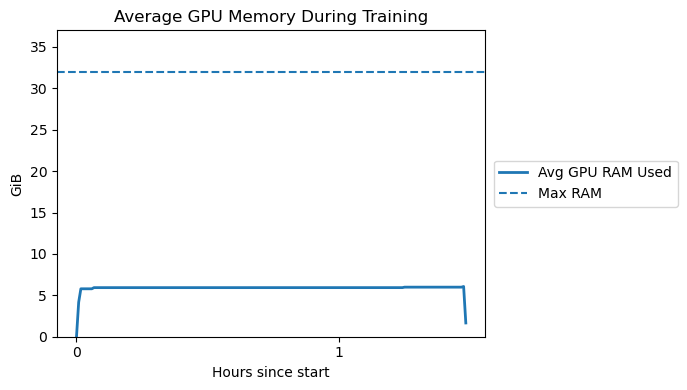

In [5]:
fig = exp.plot_gpu_usage()
fig.show()

### Correlation btw True and Predicted TG Expression

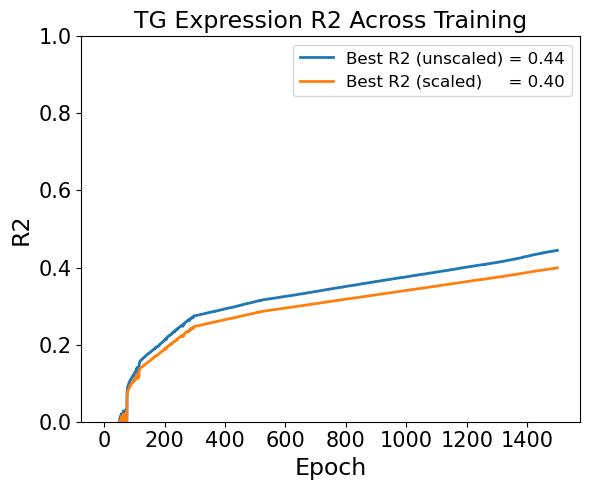

In [4]:
fig = exp.plot_train_correlation()
fig.show()

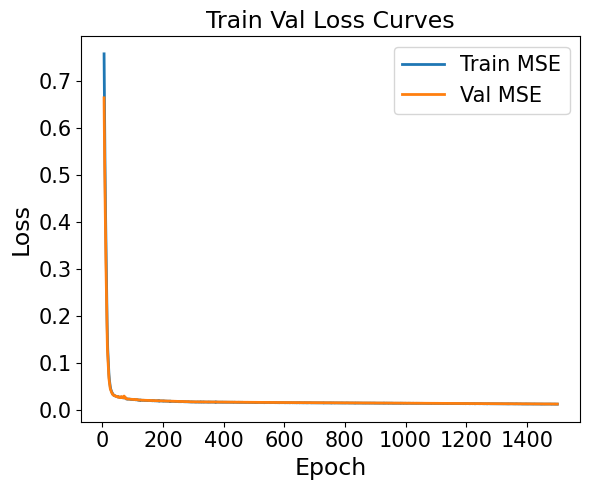

In [12]:
fig = exp.plot_train_val_loss()
fig.show()

### AUROC boxplots compared to other methods

#### Pooled AUROC

In [6]:
fig = exp.plot_pooled_auroc_boxplot(ylim=(0.2, 0.8))
fig.show()

AssertionError: Pooled AUROC/AUPRC results file does not exist for K562_small_model_long_training, model_training_002

#### Per-TF AUROC where each point represents a TF's mean AUROC score across all ground truth datasets

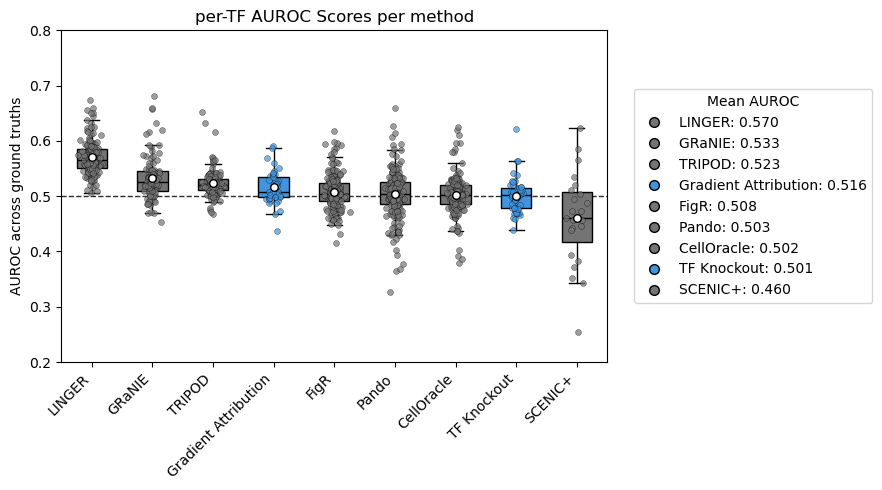

In [ ]:
fig = exp.plot_per_tf_auroc_boxplot(agg_by_gt=False, ylim=(0.2, 0.8))
fig.show()

#### Per-TF AUROC where each point represents a ground truth's mean per-TF AUROC score

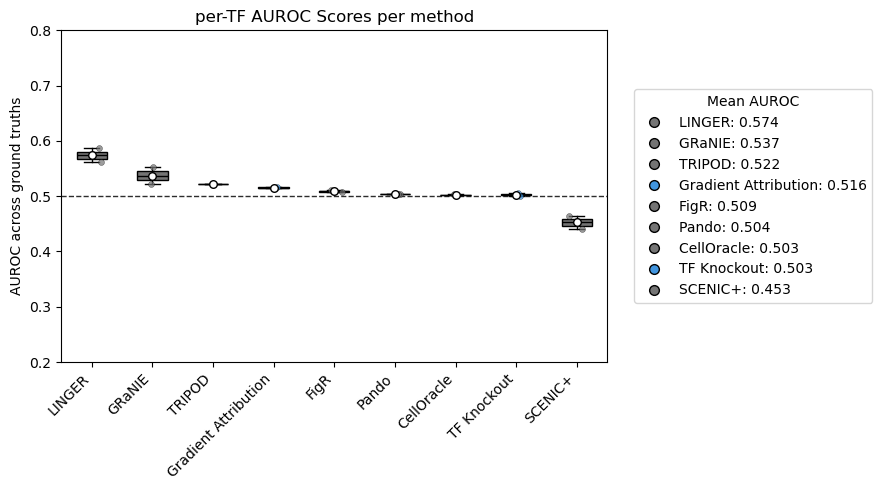

In [ ]:
fig = exp.plot_per_tf_auroc_boxplot(agg_by_gt=True, ylim=(0.2, 0.8))
fig.show()

## Load the Inferred GRNs

In [7]:
grad_df = exp.load_grn("Gradient Attribution")
grad_df

,Source,Target,Score
0,AHRR,5S_RRNA,0.000000
1,AHRR,5_8S_RRNA,0.000000
2,AHRR,7SK,0.000000
3,AHRR,A1BG,0.000000
4,AHRR,A1BG-AS1,0.000000
...,...,...,...
5544781,ZSCAN31,ZYG11B,0.000000
5544782,ZSCAN31,ZYX,22.557562
5544783,ZSCAN31,ZYXP1,0.000000
5544784,ZSCAN31,ZZEF1,0.000000


In [8]:
tf_ko_df = exp.load_grn("TF Knockout")
tf_ko_df

,Source,Target,Score
0,AHRR,5S_RRNA,0.000000
1,AHRR,5_8S_RRNA,0.000000
2,AHRR,7SK,0.000000
3,AHRR,A1BG,0.000000
4,AHRR,A1BG-AS1,0.000000
...,...,...,...
5544781,ZSCAN31,ZYG11B,0.000000
5544782,ZSCAN31,ZYX,22.567234
5544783,ZSCAN31,ZYXP1,0.000000
5544784,ZSCAN31,ZZEF1,0.000000


## Compare the GRN to a ground truth

In [18]:
sample_type = exp.experiment_name.split("_")[0]


print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}")

grad_df = exp.load_grn("Gradient Attribution")
ground_truth_pooled_metrics = []
for ground_truth_name in gt_by_dataset_dict[sample_type].keys():
    print(f"  - Ground truth: {ground_truth_name}")
    gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

    pooled_metrics_df = exp.generate_pooled_metrics(
        method_name="Gradient Attribution",
        score_df=grad_df,
        ground_truth=gt_df,
        ground_truth_name=ground_truth_name,
        top_fracs=(0.001, 0.005, 0.01, 0.05),
        balance=True,
    )
    
    ground_truth_pooled_metrics.append(pooled_metrics_df)
    
pooled_metrics_df = pd.concat(ground_truth_pooled_metrics)

pooled_metrics_df

Experiment: K562_small_model_long_training, Sample type: K562
  - Ground truth: ChIP-Atlas K562
  - Ground truth: RN117


,method,gt,auroc,auprc
0,Gradient Attribution,ChIP-Atlas K562,0.516541,0.515322
0,Gradient Attribution,RN117,0.519233,0.517132


In [19]:
sample_type = exp.experiment_name.split("_")[0]


print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}")

grad_df = exp.load_grn("Gradient Attribution")

gt_per_tf_metrics = []
for ground_truth_name in gt_by_dataset_dict[sample_type].keys():
    print(f"  - Ground truth: {ground_truth_name}")
    gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]


    per_tf_metrics_df = exp.generate_per_tf_metrics(
        method_name="Gradient Attribution",
        score_df=grad_df,
        ground_truth=gt_df,
        ground_truth_name=ground_truth_name,
        top_fracs=(0.001, 0.005, 0.01, 0.05),
        balance=True,
    )
    
    gt_per_tf_metrics.append(per_tf_metrics_df)
    
per_tf_metrics_df = pd.concat(gt_per_tf_metrics)

per_tf_metrics_df

Experiment: K562_small_model_long_training, Sample type: K562
  - Ground truth: ChIP-Atlas K562
  - Ground truth: RN117


,method,gt,tf,n_edges,n_pos,n_neg,pos_rate,auroc,auprc
0,Gradient Attribution,ChIP-Atlas K562,ATF3,40148,24460,15688,0.609246,0.516541,0.515322
1,Gradient Attribution,ChIP-Atlas K562,BCL6,40148,784,39364,0.019528,0.516541,0.515322
2,Gradient Attribution,ChIP-Atlas K562,CGGBP1,40148,807,39341,0.020101,0.516541,0.515322
3,Gradient Attribution,ChIP-Atlas K562,CREB3L1,40148,9639,30509,0.240087,0.516541,0.515322
4,Gradient Attribution,ChIP-Atlas K562,CREB5,40148,602,39546,0.014995,0.516541,0.515322
...,...,...,...,...,...,...,...,...,...
12,Gradient Attribution,RN117,SOX6,26089,58,26031,0.002223,0.519233,0.517132
13,Gradient Attribution,RN117,TCF7L2,26089,3046,23043,0.116754,0.519233,0.517132
14,Gradient Attribution,RN117,ZBTB11,26089,5956,20133,0.228295,0.519233,0.517132
15,Gradient Attribution,RN117,ZNF143,26089,15982,10107,0.612595,0.519233,0.517132


## Plot the AUROC and AUPRC curves vs a Ground Truth

In [ ]:
grad_df_nonzero = grad_df[grad_df["Score"] > 0]
tf_ko_df_nonzero = tf_ko_df[tf_ko_df["Score"] > 0]

merged_df = pd.merge(
    grad_df_nonzero, 
    tf_ko_df_nonzero, 
    how="inner", 
    on=["Source", "Target"],
    suffixes=("_grad", "_tf_ko"),
)

merged_df["Score"] = merged_df["Score_grad"] + merged_df["Score_tf_ko"]

merged_df

,Source,Target,Score_grad,Score_tf_ko,Score
0,AHRR,1110046J04RIK,8.429986,3.108622,11.538609
1,AHRR,1500015A07RIK,102.155006,23.073353,125.228363
2,AHRR,1600002D24RIK,91.989555,19.338455,111.328011
3,AHRR,1600010M07RIK,2378.802979,563.045166,2941.848145
4,AHRR,1700001K19RIK,82.289391,22.658007,104.947395
...,...,...,...,...,...
521603,ZIC2,ZFPM2,1516.992798,100.162239,1617.155029
521604,ZIC2,ZIC2,41069.964844,7600.640137,48670.605469
521605,ZIC2,ZMAT4,1521.148804,215.553558,1736.702393
521606,ZIC2,ZSWIM5,3152.113770,833.001038,3985.114746


In [3]:

sample_type = exp.experiment_name.split("_")[0]
ground_truth_name = list(gt_by_dataset_dict[sample_type].keys())[1]

print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}, Ground truth: {ground_truth_name}")

grad_df = exp.load_grn("Gradient Attribution", zscore_method="mean_std")
gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

fig, overlap_info_df = exp.plot_auroc_auprc(
    grad_df, 
    gt_df, 
    ground_truth_name=ground_truth_name, 
    return_overlap_info=True,
    balance=True,
    save_fig=False,
    )
fig.show()

overlap_info_df


NameError: name 'gt_by_dataset_dict' is not defined

## Generate performance metrics for multiple experiments

In [ ]:
experiments = [
    "Macrophage_buffer_1_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_disp_0.01",
    # "Macrophage_buffer_3_hvg_filter_disp_0.01",
    # "Macrophage_buffer_4_hvg_filter_disp_0.01",
    # "Macrophage_buffer_2_hvg_filter_none",
    # "Macrophage_buffer_1_best_settings",
    # "Macrophage_buffer_2_best_settings",
    # "Macrophage_all_bnchmk_best_settings",
    "mESC_E7.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E7.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep2_hvg_filter_disp_0.01",
    "mESC_E7.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep1_hvg_filter_disp_0.5",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.01",
    # "mESC_E8.5_rep2_hvg_filter_disp_0.5",
    # "mESC_E7.5_rep1_best_settings",
    # "mESC_E7.5_rep2_best_settings",
    # "mESC_E8.5_rep1_best_settings",
    "K562_hvg_filter_disp_0.01",
    # "K562_hvg_filter_disp_0.5",
    # "K562_hvg_filter_none",
    # "K562_sample_1_best_settings"
]

all_gt_results = []
for experiment_name in experiments:
    print(f"Processing experiment: {experiment_name}")
    if "macrophage" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["Macrophage"]
        sample_type = "Macrophage"
    elif "mesc" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["mESC"]
        sample_type = "mESC"
    elif "k562" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["K562"]
        sample_type = "K562"
        
    exp = experiment_loader.ExperimentLoader(
        experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
        experiment_name=experiment_name,
        model_num=1,
    )

    grad_df = exp.load_grn("Gradient Attribution")
        
    for gt_name, gt_df in gt_dict.items():
        print(f"  - Processing ground truth: {gt_name}")
        fig, overlap_info_df = exp.plot_auroc_auprc(
            grad_df, 
            gt_df, 
            ground_truth_name=gt_name, 
            return_overlap_info=True,
            balance=True,
            no_fig=True,
            )
        results_dict = {
            "sample_type": sample_type,
            "experiment": experiment_name,
            "ground_truth": gt_name,
            "num_tf_in_gt": overlap_info_df.loc["TFs", "Overlap (Score DF in GT)"],
            "pct_tf_overlap": overlap_info_df.loc["TFs", "Pct of GRN in GT"],
            "pct_tg_overlap": overlap_info_df.loc["TGs", "Pct of GRN in GT"],
            "pct_edges_in_gt": overlap_info_df.loc["edges", "Pct of GRN in GT"],
        }

        results_df = pd.DataFrame(results_dict, index=[0])
        
        merged_results = pd.merge(results_df, exp.auroc_auprc_scores, on=["experiment", "ground_truth"], how="left")
        
        all_gt_results.append(merged_results)

full_results_df = pd.concat(all_gt_results, axis=0)
full_results_df


Processing experiment: Macrophage_buffer_1_best_settings
  - Processing ground truth: RN204
  - Processing ground truth: ChIP-Atlas macrophage
Processing experiment: Macrophage_buffer_2_best_settings
  - Processing ground truth: RN204
  - Processing ground truth: ChIP-Atlas macrophage
Processing experiment: mESC_E7.5_rep1_best_settings
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: mESC_E7.5_rep2_best_settings
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Processing experiment: mESC_E8.5_rep1_best_settings
  - Processing ground truth: ChIP-Atlas mESC
  - Processing ground truth: RN111
  - Processing ground truth: RN112
  - Processing ground truth: RN114
  - Processing ground truth: RN116
Pro

,experiment,ground_truth,auroc,auprc
0,Macrophage_buffer_1_best_settings,RN204_combined,0.599095,0.601909
1,Macrophage_buffer_1_best_settings,RN204_grad,0.597227,0.601610
2,Macrophage_buffer_1_best_settings,RN204_tf_ko,0.551697,0.564304
0,Macrophage_buffer_1_best_settings,RN204_combined,0.599095,0.601909
1,Macrophage_buffer_1_best_settings,RN204_grad,0.597227,0.601610
...,...,...,...,...
1,K562_sample_1_best_settings,ChIP-Atlas K562_grad,0.453925,0.469745
2,K562_sample_1_best_settings,ChIP-Atlas K562_tf_ko,0.468942,0.471482
3,K562_sample_1_best_settings,RN117_combined,0.492335,0.489792
4,K562_sample_1_best_settings,RN117_grad,0.484450,0.485157


In [ ]:
def plot_auroc_improvement_boxplot(
    full_results_df, 
    column="auroc", 
    title="AUROC Variance across Ground Truths",
    hbar_y=0,
    ylim=(-0.3, 0.3)
    ):
    # ---- group data by ground_truth ----
    groups = full_results_df.groupby("ground_truth")[column]
    labels = groups.groups.keys()
    data = [groups.get_group(g).values for g in labels]

    color_dict = {
        "ChIP-Atlas mESC": "#da8b47",
        "ChIP-Atlas macrophage": "#e67d5f",
        "ChIP-Atlas K562": "#dab45d",
        "RN111": "#71c071",
        "RN112": "#ba4444",
        "RN114": "#cbb4e1",
        "RN116": "#91645b",
        "RN117": "#d8aacb",
        "RN204": "#9ec5e1",
    }

    means = [np.mean(groups.get_group(g)) for g in labels]

    plt.figure(figsize=(10, 6))
    # ---- boxplot ----
    bp = plt.boxplot(
        data,
        patch_artist=True,
        showfliers=False,
        zorder=1,
    )

    plt.axhline(hbar_y, color="#747474", linestyle="--")


    # ---- color boxes ----
    for label, box in zip(labels, bp["boxes"]):
        box.set_facecolor(color_dict.get(label, "#4195df"))
    for median in bp["medians"]:
        median.set_color("black")

    # ---- scatter points ----
    for i, g in enumerate(labels, start=1):
        yvals = groups.get_group(g).values
        xvals = np.random.normal(i, 0.05, size=len(yvals))  # jitter per box
        
        plt.scatter(
            xvals,
            yvals,
            color=color_dict.get(g, "#4195df"),
            alpha=0.7,
            s=40,
            edgecolor="k",
            zorder=2
        )

    # ---- plot mean per ground_truth ----

    plt.scatter(
        range(1, len(means) + 1),
        means,
        color="white",
        s=60,
        edgecolor="k",
        zorder=3,
    )

    # ---- formatting ----
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(f"{column}\n(per experiment)", fontsize=14)
    plt.title(f"{title}", fontsize=14)

    # ---- plot mean per ground_truth + build legend ----
    legend_handles = []

    for i, (g, m) in enumerate(zip(labels, means), start=1):
        h = plt.scatter(
            i,
            m,
            color="white",
            s=70,
            edgecolor="k",
            zorder=3,
            label=f"{g} mean = {m:.3f}"
        )
        legend_handles.append(h)


    plt.legend(
        handles=legend_handles,
        bbox_to_anchor=(1.02, 0.75),
        loc="upper left",
        frameon=False,
        fontsize=12,
        title="Mean AUROC",
        title_fontsize=14,
    )

    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


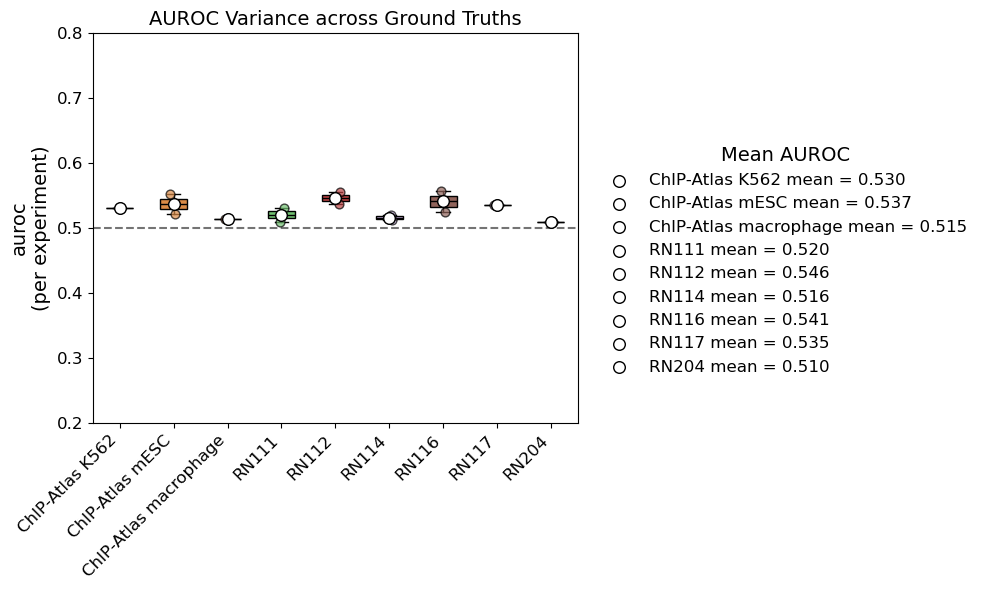

In [ ]:
plot_auroc_improvement_boxplot(
    full_results_df, 
    ylim=(0.2, 0.8),
    hbar_y=0.5
    )


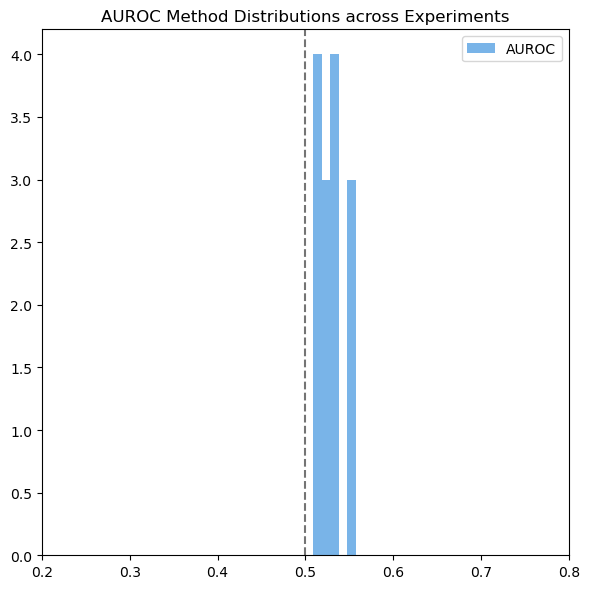

In [ ]:
fig = plt.figure(figsize=(6, 6))

plt.hist(full_results_df["auroc"], bins=5, color="#4195df", alpha=0.7, label="AUROC")
plt.axvline(0.5, color="#747474", linestyle="--")
plt.legend()
plt.xlim(0.2, 0.8)
plt.title("AUROC Method Distributions across Experiments")
plt.tight_layout()
plt.show()


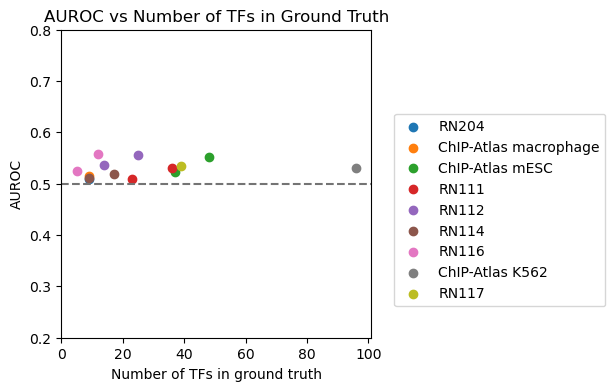

In [ ]:
# Scatterplot of auroc vs percent of tf overlap in gt
plt.figure(figsize=(4,4))
# df = full_results_df[full_results_df["sample_type"] == "K562"]
df = full_results_df
for gt_name in df["ground_truth"].unique():
    subset = df[df["ground_truth"] == gt_name]
    plt.scatter(subset["num_tf_in_gt"], subset["auroc"], label=gt_name)
plt.title("AUROC vs Number of TFs in Ground Truth")
plt.xlabel("Number of TFs in ground truth")
plt.ylabel("AUROC")
plt.hlines(0.5, xmin=0, xmax=df["num_tf_in_gt"].max() +5, color="#747474", linestyle="--")
plt.legend(
    bbox_to_anchor=(1.05, 0.75), loc='upper left'
)

plt.ylim(0.2, 0.8)
plt.xlim(0, df["num_tf_in_gt"].max() + 5)

plt.show()

### Load the AUROC and AUPRC comparison results

In [ ]:
exp.load_eval_results()
results_df = exp.results_df[exp.results_df["method"] == "Gradient Attribution"]
results_df

,method,gt,auroc,auprc,pos_rate,lift_auprc,precision@0.10%,lift@0.10%,precision@0.50%,lift@0.50%,precision@1.00%,lift@1.00%,precision@5.00%,lift@5.00%
14,Gradient Attribution,ChIP-Atlas,0.530222,0.522556,0.5,1.045112,0.793307,1.586614,0.747606,1.495212,0.715813,1.431626,0.663536,1.327072
15,Gradient Attribution,RN117,0.535325,0.525976,0.5,1.051951,0.977011,1.954023,0.816280,1.632559,0.705792,1.411585,0.636642,1.273284


## Compare Predicted vs True TG Expression

You can test the model's ability to predict TG expression using `run_forward_pass`, which runs the model predictions for the held-out test dataset. This returns three dataframes, one with the predicted TG expression, one with the true TG expression, and one that compares the per-gene mean and standard deviation of the predicted and true expression.

In [ ]:
tg_expr_pred_df, tg_expr_true_df, pred_true_comparison_df = exp.run_forward_pass(num_batches=10)

Running forward pass:   0%|                              | 0/10 [00:00<?, ?it/s]/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/datasets/dataset_refactor.py:501: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. P

In [ ]:
tg_expr_pred_df

,E7.5_REP1.GGGCATTGTGAAGCCT,E7.5_REP1.TGAAGCAAGTTATCTC,E7.5_REP1.TAGTGTGGTCCTAGTT,E7.5_REP1.CAGGACCTCTAGCGTG,E7.5_REP1.CCGATGCAGCTCAAAC,E7.5_REP1.ACAGGTAAGGCTGGCT,E7.5_REP1.AGGTACGCAGCATGTC,E7.5_REP1.CGGACAACAAGGTCGA,E7.5_REP1.CTATGTTTCGAAGTGA,E7.5_REP1.AATCCTAAGGACCAGG,...,E7.5_REP1.CCTACTGGTTTGCTGT,E7.5_REP1.TATCCGGAGCACTAAC,E7.5_REP1.TCGTTACGTCGCGCAA,E7.5_REP1.GCATTAGGTTAGTACG,E7.5_REP1.CGTTGCAAGCGAGCGA,E7.5_REP1.TACAGCTAGCTTCCCG,E7.5_REP1.ACTTGTAAGTTAGGCT,E7.5_REP1.ACCAGGGAGGAGCAAC,mean_expr,std_expr
1700034P13RIK,0.248536,0.194882,0.401311,0.362949,0.186195,0.228717,0.322298,0.358958,0.240103,0.305966,...,0.235399,0.262733,0.238011,0.177614,0.157412,0.243613,0.257622,0.170101,0.248881,0.062023
4933439K11RIK,0.058995,0.012181,0.073879,0.064206,0.093903,0.015990,0.092454,0.091047,0.084056,0.088779,...,0.026485,0.066840,0.038681,0.087896,0.026159,0.019476,0.019129,0.005522,0.059956,0.031179
A830018L16RIK,0.204982,0.131254,0.265168,0.134749,0.134902,0.078543,0.227991,0.172285,0.308803,0.327793,...,0.171083,0.479135,0.200979,0.186525,0.190024,0.180026,0.117921,0.105808,0.219224,0.082495
ACKR3,0.076203,0.052959,0.019358,0.060715,0.049223,0.031722,0.047309,0.079982,0.045174,0.041970,...,0.059900,0.058461,0.088294,0.092294,0.007059,0.076868,0.065637,0.083965,0.056673,0.028229
ADAM23,0.172590,0.167548,0.412202,0.308133,0.220931,0.198963,0.274084,0.302987,0.296407,0.306860,...,0.227115,0.376457,0.157011,0.243261,0.263480,0.193975,0.185382,0.236779,0.240292,0.059164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSGA10,0.046319,0.072588,0.048271,0.038604,0.061444,0.051922,0.048401,0.046506,0.042991,0.039521,...,0.050989,0.048780,0.034214,0.051816,0.040063,0.078153,0.071471,0.052390,0.053040,0.019578
WNT6,-0.005273,0.192644,0.020789,-0.002852,0.047563,0.213799,0.063198,0.043498,0.044433,0.076351,...,0.157337,0.028736,0.061351,0.026779,0.031094,0.203321,0.149476,0.009725,0.062821,0.058396
XKR4,0.413053,0.372439,0.951058,0.707596,0.553170,0.417721,0.724789,0.580544,0.805579,0.692968,...,0.530626,0.940677,0.426748,0.418556,0.411652,0.480697,0.490115,0.273629,0.537457,0.185520
XPR1,0.270651,0.299059,0.437323,0.392474,0.319145,0.315101,0.350606,0.471033,0.350064,0.368228,...,0.469741,0.374451,0.364961,0.338745,0.838005,0.400279,0.396498,0.154319,0.415381,0.176251


In [ ]:
tg_expr_true_df

,E7.5_REP1.GGGCATTGTGAAGCCT,E7.5_REP1.TGAAGCAAGTTATCTC,E7.5_REP1.TAGTGTGGTCCTAGTT,E7.5_REP1.CAGGACCTCTAGCGTG,E7.5_REP1.CCGATGCAGCTCAAAC,E7.5_REP1.ACAGGTAAGGCTGGCT,E7.5_REP1.AGGTACGCAGCATGTC,E7.5_REP1.CGGACAACAAGGTCGA,E7.5_REP1.CTATGTTTCGAAGTGA,E7.5_REP1.AATCCTAAGGACCAGG,...,E7.5_REP1.CCTACTGGTTTGCTGT,E7.5_REP1.TATCCGGAGCACTAAC,E7.5_REP1.TCGTTACGTCGCGCAA,E7.5_REP1.GCATTAGGTTAGTACG,E7.5_REP1.CGTTGCAAGCGAGCGA,E7.5_REP1.TACAGCTAGCTTCCCG,E7.5_REP1.ACTTGTAAGTTAGGCT,E7.5_REP1.ACCAGGGAGGAGCAAC,mean_expr,std_expr
1700034P13RIK,0.226129,0.217746,0.243371,0.242042,0.223723,0.217609,0.232503,0.248120,0.229137,0.236043,...,0.225596,0.230251,0.237649,0.228262,0.227165,0.229064,0.223981,0.217739,0.229265,0.007096
4933439K11RIK,0.061865,0.061797,0.063117,0.063484,0.063482,0.060743,0.065487,0.064783,0.064488,0.064517,...,0.061422,0.062575,0.062144,0.063551,0.060574,0.060994,0.062000,0.060626,0.062850,0.001425
A830018L16RIK,0.178597,0.190195,0.296291,0.235996,0.184717,0.181181,0.285189,0.175902,0.296989,0.300448,...,0.179373,0.352525,0.173684,0.177252,0.174329,0.177122,0.175773,0.199060,0.214993,0.046409
ACKR3,0.053601,0.049166,0.049750,0.049585,0.049257,0.049103,0.052238,0.057507,0.051030,0.048707,...,0.048448,0.051024,0.057748,0.058270,0.049092,0.049234,0.048986,0.049323,0.051429,0.003510
ADAM23,0.123841,0.115780,0.182354,0.155069,0.144221,0.115760,0.147910,0.125998,0.149117,0.134293,...,0.116321,0.176955,0.118982,0.126302,0.117347,0.116213,0.116189,0.122491,0.133387,0.019298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TSGA10,0.047826,0.048603,0.047128,0.047919,0.048000,0.047029,0.048734,0.047699,0.047197,0.046798,...,0.047572,0.047164,0.047052,0.048723,0.047962,0.048361,0.047131,0.048639,0.047780,0.000895
WNT6,0.112490,0.170503,0.113807,0.109848,0.119853,0.172631,0.116232,0.113044,0.109291,0.142474,...,0.163805,0.109609,0.114936,0.119299,0.111587,0.158354,0.169788,0.109398,0.122815,0.019482
XKR4,0.387535,0.406876,0.655436,0.553686,0.463165,0.442603,0.664958,0.427894,0.781727,0.651449,...,0.526942,0.812488,0.407075,0.430512,0.364082,0.450013,0.446112,0.380900,0.495164,0.130765
XPR1,0.534073,0.606463,0.597323,0.569363,0.555388,0.596414,0.550117,0.552769,0.552878,0.593411,...,0.611557,0.572248,0.547062,0.550061,0.810197,0.581046,0.576806,0.537271,0.604644,0.082219


In [ ]:
pred_true_comparison_df

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
1700034P13RIK,0.248881,0.062023,0.229265,0.007096,0.019616
4933439K11RIK,0.059956,0.031179,0.062850,0.001425,-0.002894
A830018L16RIK,0.219224,0.082495,0.214993,0.046409,0.004231
ACKR3,0.056673,0.028229,0.051429,0.003510,0.005244
ADAM23,0.240292,0.059164,0.133387,0.019298,0.106905
...,...,...,...,...,...
TSGA10,0.053040,0.019578,0.047780,0.000895,0.005261
WNT6,0.062821,0.058396,0.122815,0.019482,-0.059994
XKR4,0.537457,0.185520,0.495164,0.130765,0.042293
XPR1,0.415381,0.176251,0.604644,0.082219,-0.189263


### Plot the True vs Predicted TG Expression Values

You can also compare how well the model predicts the TG expression using `plot_true_vs_predicted_tg_expression`, which creates a scatterplot of each gene's predicted mean expression vs its true mean expression.

Running forward pass to get predicted vs true TG expression for a subset of test batches...
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/utils/experiment_loader.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the load

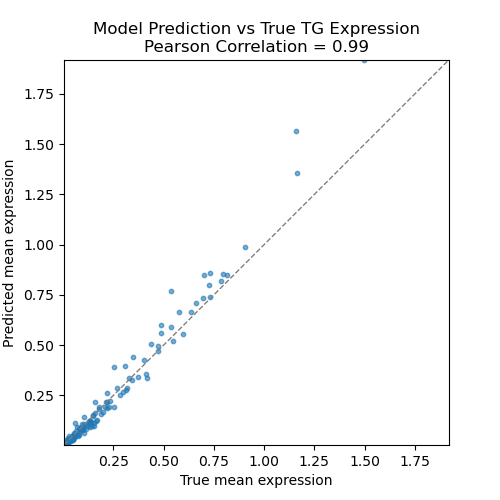

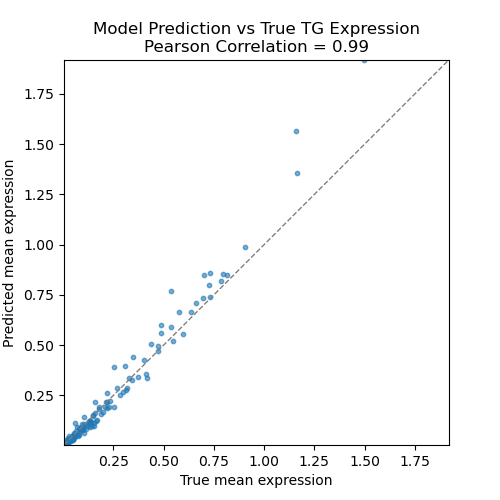

In [ ]:
fig = exp.plot_true_vs_predicted_tg_expression(num_batches=25, rerun_forward_pass=False)
fig.show()

### Plot Prediction Accuracy vs Gene Expression Variance

We can also see that the model tends to struggle more to accurately predict the mean expression for genes with a high variance by plotting the per-gene prediction accuracy by the standard deviation of the gene's expression.

In [ ]:
pred_true_comparison_df

,mean_expr_pred,std_expr_pred,mean_expr_true,std_expr_true,diff
1700034P13RIK,0.199774,0.026320,0.165706,0.003370,0.034068
4930444P10RIK,0.010146,0.010695,0.008702,0.000239,0.001444
4933439K11RIK,0.073442,0.019137,0.050509,0.001041,0.022934
A330023F24RIK,0.101264,0.040298,0.084410,0.006777,0.016854
A830018L16RIK,0.151198,0.049027,0.111960,0.015990,0.039238
...,...,...,...,...,...
UNC80,0.049863,0.021988,0.040782,0.002452,0.009081
USH2A,0.010172,0.006704,0.007538,0.000088,0.002634
WNT6,0.163958,0.057478,0.124215,0.017769,0.039743
XKR4,0.310537,0.070668,0.274288,0.053005,0.036249


Spearman: rho = -0.241, p-value = 0.002


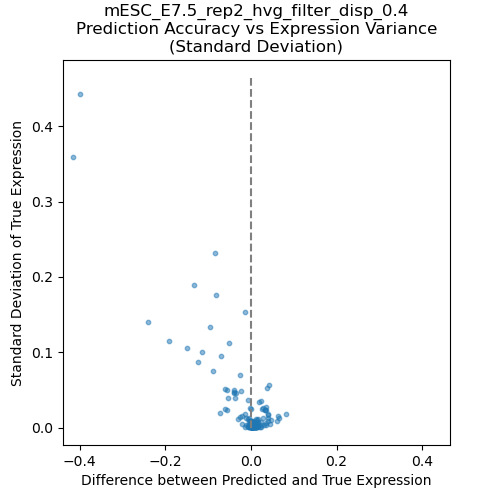

In [ ]:
from scipy.stats import spearmanr

fig = plt.figure(figsize=(5,5))

plt.scatter(pred_true_comparison_df["diff"], pred_true_comparison_df["std_expr_true"], alpha=0.5, s=10)

lims = [
    np.min([plt.xlim()[0], plt.ylim()[0]]),  # min of both axes
    np.max([plt.xlim()[1], plt.ylim()[1]]),  # max of both axes
]
plt.vlines(x=0, ymin=0, ymax=lims[1], colors='grey', linestyles='dashed', label="Perfect Prediction")
plt.xlim(lims)
plt.title(f"{exp.experiment_name}\nPrediction Accuracy vs Expression Variance\n(Standard Deviation)")
plt.xlabel("Difference between Predicted and True Expression")
plt.ylabel("Standard Deviation of True Expression")

spearman_corr = spearmanr(pred_true_comparison_df["diff"], pred_true_comparison_df["std_expr_true"])

print(f"Spearman: rho = {spearman_corr[0]:.3f}, p-value = {spearman_corr[1]:.3f}")

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
experiment_dir = Path("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/")
experiments = [i for i in experiment_dir.iterdir() if i.is_dir() and i.name.startswith(tuple([e for e in ["K562", "mESC", "Macrophage"] if e in i.name]))]

all_gt_results = []
for experiment_path in experiments:
    experiment_name = experiment_path.name
    
    if "macrophage" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["Macrophage"]
        sample_type = "Macrophage"
    elif "mesc" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["mESC"]
        sample_type = "mESC"
    elif "k562" in experiment_name.lower():
        gt_dict = gt_by_dataset_dict["K562"]
        sample_type = "K562"
    
    try:
        exp = experiment_loader.ExperimentLoader(
            experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
            experiment_name=experiment_name,
            model_num=1,
            silence_warnings=True,
        )
    except (AssertionError, FileNotFoundError) as e:
        continue

    try:
        exp.load_eval_results()
        results_df = exp.results_df.copy()
        results_df["experiment"] = experiment_name
        results_df = results_df[results_df["method"] == "Gradient Attribution"]
        results_df = results_df.groupby(["experiment", "method"])[["auroc", "auprc"]].mean().reset_index()
        
        results_df["genes"] = exp.model_training_params["genes"]
        results_df["windows"] = exp.model_training_params["windows"]
        results_df["tfs"] = exp.model_training_params["tfs"]
        results_df["metacells"] = exp.model_training_params["metacells"]
        
        all_gt_results.append(results_df)
    except (AssertionError, FileNotFoundError) as e:
        continue
    
    print(f"Processed experiment: {experiment_name}")
    
all_gt_results_df = pd.concat(all_gt_results)


all_gt_results_df


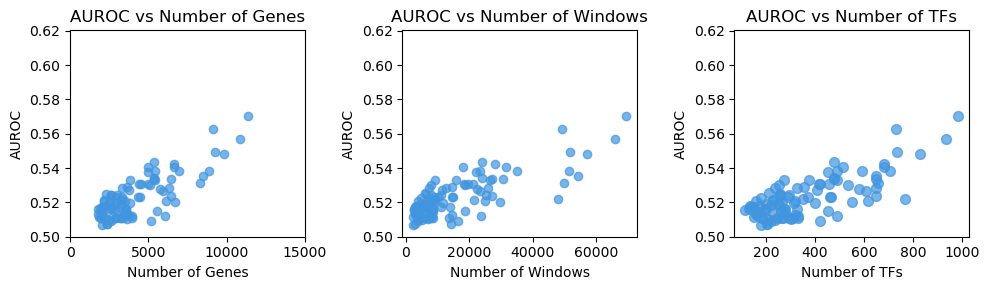

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

ax[0].scatter(all_gt_results_df["genes"], all_gt_results_df["auroc"], color="#4195df", alpha=0.7)
ax[0].set_xlabel("Number of Genes")
ax[0].set_ylabel("AUROC")
ax[0].set_title("AUROC vs Number of Genes")
ax[0].set_ylim(0.5, max(all_gt_results_df["auroc"]) + 0.05)
ax[0].set_xlim(0, 15000)


ax[1].scatter(all_gt_results_df["windows"], all_gt_results_df["auroc"], color="#4195df", alpha=0.7)
ax[1].set_xlabel("Number of Windows")
ax[1].set_ylabel("AUROC")
ax[1].set_title("AUROC vs Number of Windows")
ax[1].set_ylim(0.5, max(all_gt_results_df["auroc"]) + 0.05)


ax[2].scatter(all_gt_results_df["tfs"], all_gt_results_df["auroc"], color="#4195df", alpha=0.7, s=50)
ax[2].set_xlabel("Number of TFs")
ax[2].set_ylabel("AUROC")
ax[2].set_title("AUROC vs Number of TFs")
ax[2].set_ylim(0.5, max(all_gt_results_df["auroc"]) + 0.05)

plt.tight_layout()
plt.show()

## Do the AUROC curves get better as the model learns?


In [45]:
from multiomic_transformer.scripts import gradient_attribution

In [129]:
import importlib
importlib.reload(gradient_attribution)

<module 'multiomic_transformer.scripts.gradient_attribution' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/multiomic_transformer/scripts/gradient_attribution.py'>

In [48]:
def format_grad_df(grad_attr_np, tf_names, tg_names):
    score = np.nan_to_num(grad_attr_np, nan=0.0)
    score_abs = np.abs(score)
    
    median_val = np.median(score_abs, axis=1, keepdims=True)
    mad = np.median(np.abs(score_abs - median_val), axis=1, keepdims=True) + 1e-6
    score = (score_abs - median_val) / mad
    
    T, G = score_abs.shape
    tf_idx, tg_idx = np.meshgrid(np.arange(T), np.arange(G), indexing="ij")
    
    tf_idx = tf_idx.ravel()
    tg_idx = tg_idx.ravel()

    df = pd.DataFrame({
        "Source": np.asarray(tf_names, dtype=object)[tf_idx],
        "Target": np.asarray(tg_names, dtype=object)[tg_idx],
        "Score": score.ravel(),
    })
    
    df["Source"] = df["Source"].astype(str).str.upper()
    df["Target"] = df["Target"].astype(str).str.upper()
    
    return df
            

In [122]:
exp = experiment_loader.ExperimentLoader(
    experiment_dir = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/",
    experiment_name="mESC_E7.5_rep1_hvg_filter_disp_0.01",
    model_num=1,
)

In [105]:
def find_n_evenly_spaced_checkpoints(exp, n=10):
    checkpoints = sorted([file.name for file in exp.model_training_dir.iterdir() if file.name.startswith("checkpoint_")], key=lambda x: int(x.split("_")[1].split(".")[0]))
    checkpoint_nums = [int(name.split("_")[1].split(".")[0]) for name in checkpoints]

    max_checkpoint = checkpoint_nums[-1]

    # Process n checkpoints, evenly spaced across the range of available checkpoints
    num_to_process = min(n, len(checkpoint_nums))
    checkpoints_to_process = np.linspace(0, max_checkpoint, num=num_to_process, dtype=int)
    
    # Round to the nearest available checkpoint number
    checkpoints_to_process = [min(checkpoint_nums, key=lambda x: abs(x - num)) for num in checkpoints_to_process]
    checkpoints_to_process = sorted(set(checkpoints_to_process))
    
    print(f"Checkpoint Numbers to process: {checkpoints_to_process}")
    
    checkpoint_files = [f"checkpoint_{num}.pt" for num in checkpoints_to_process]
    
    return checkpoint_files, checkpoints_to_process

In [124]:
import time

sample_type = exp.experiment_name.split("_")[0]
gt_names = list(gt_by_dataset_dict[sample_type].keys())

print(f"Experiment: {exp.experiment_name}, Sample type: {sample_type}")

# checkpoints, checkpoint_nums = find_n_evenly_spaced_checkpoints(exp, n=5)

checkpoints = ["checkpoint_0.pt", "trained_model.pt"]
checkpoint_nums = [0, 1]

print()
ground_truth_pooled_metrics = []
for checkpoint_name, checkpoint_num in zip(checkpoints, checkpoint_nums):
    
    exp.load_trained_model(checkpoint_name)
    model = exp.model
    max_batches = 50 # len(exp.test_loader)
    
    print(f"Processing checkpoint: {checkpoint_name}")
    
    start_time = time.time()
    grad_attr_np = gradient_attribution.run_gradient_attribution(
        selected_experiment_dir=exp.model_training_dir,
        model=model,
        test_loader=exp.test_loader,
        tg_scaler=exp.tg_scaler,
        tf_scaler=exp.tf_scaler,
        state=exp.state,
        use_amp=False,
        rank=0,
        world_size=1,
        distributed=False,
        use_dataloader=False,
        max_batches=max_batches,
        device=exp.device,
        
    )
    
    end_time = time.time()
    print(f"  - Gradient attribution finished {max_batches} batches in {end_time - start_time:.2f} seconds.")
    
    grad_df = format_grad_df(grad_attr_np, exp.tf_names, exp.tg_names)

    for ground_truth_name in gt_names:
        print(f"  - Ground truth: {ground_truth_name}")
        gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

        pooled_metrics_df = exp.generate_pooled_metrics(
            method_name="Gradient Attribution",
            score_df=grad_df,
            ground_truth=gt_df,
            ground_truth_name=ground_truth_name,
            top_fracs=(0.001, 0.005, 0.01, 0.05),
            balance=True,
        )
        
        pooled_metrics_df["checkpoint_name"] = checkpoint_name
        
        ground_truth_pooled_metrics.append(pooled_metrics_df)
        
pooled_metrics_df = pd.concat(ground_truth_pooled_metrics)

pooled_metrics_df

Experiment: mESC_E7.5_rep1_hvg_filter_disp_0.01, Sample type: mESC

Processing checkpoint: checkpoint_0.pt


Gradient attributions (saliency): 100%|████| 50/50 [06:38<00:00,  7.97s/batches]


  - Gradient attribution finished 50 batches in 398.66 seconds.
  - Ground truth: ChIP-Atlas mESC
  - Ground truth: RN111
  - Ground truth: RN112
  - Ground truth: RN114
  - Ground truth: RN116
Processing checkpoint: trained_model.pt


Gradient attributions (saliency): 100%|████| 50/50 [06:38<00:00,  7.97s/batches]


  - Gradient attribution finished 50 batches in 398.58 seconds.
  - Ground truth: ChIP-Atlas mESC
  - Ground truth: RN111
  - Ground truth: RN112
  - Ground truth: RN114
  - Ground truth: RN116


,method,gt,auroc,auprc,checkpoint_name
0,Gradient Attribution,ChIP-Atlas mESC,0.509896,0.511025,checkpoint_0.pt
0,Gradient Attribution,RN111,0.504896,0.502696,checkpoint_0.pt
0,Gradient Attribution,RN112,0.511075,0.505266,checkpoint_0.pt
0,Gradient Attribution,RN114,0.502883,0.501876,checkpoint_0.pt
0,Gradient Attribution,RN116,0.505592,0.501503,checkpoint_0.pt
0,Gradient Attribution,ChIP-Atlas mESC,0.509943,0.511136,trained_model.pt
0,Gradient Attribution,RN111,0.505214,0.508920,trained_model.pt
0,Gradient Attribution,RN112,0.511416,0.510387,trained_model.pt
0,Gradient Attribution,RN114,0.503073,0.504707,trained_model.pt
0,Gradient Attribution,RN116,0.506776,0.515053,trained_model.pt


In [126]:
avg_auroc = pooled_metrics_df.groupby("checkpoint_name")["auroc"].mean().reset_index()
avg_auroc

,checkpoint_name,auroc
0,checkpoint_0.pt,0.506868
1,trained_model.pt,0.507284


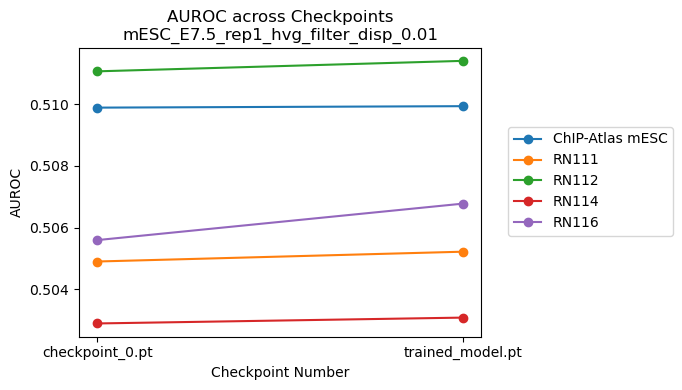

In [128]:
fig = plt.figure(figsize=(7,4))
# Plot the auroc across checkpoints, with one line per ground truth
for gt_name in pooled_metrics_df["gt"].unique():
    subset = pooled_metrics_df[pooled_metrics_df["gt"] == gt_name]
    plt.plot(subset["checkpoint_name"], subset["auroc"], marker="o", label=gt_name)

plt.title(f"AUROC across Checkpoints\n{exp.experiment_name}")
plt.xlabel("Checkpoint Number")
plt.ylabel("AUROC")
plt.legend(
    bbox_to_anchor=(1.05, 0.75), loc='upper left'
)
plt.tight_layout()
plt.show()

In [134]:
import torch
from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset_refactor import SimpleScaler

def load_model(selected_experiment_dir, checkpoint_file, device):
    params_path = selected_experiment_dir / "run_parameters.json"
    with open(params_path, "r") as f:
        params = json.load(f)

    # Pull out architecture hyperparameters
    d_model   = params.get("d_model")
    num_heads = params.get("num_heads")
    num_layers = params.get("num_layers")
    d_ff      = params.get("d_ff")
    dropout   = params.get("dropout", 0.0)
    use_shortcut   = params.get("use_shortcut", False)
    use_dist_bias  = params.get("use_dist_bias", False)
    use_motif_mask = params.get("use_motif_mask", False)

    # 1) Load test loader and checkpoint
    test_loader = torch.load(selected_experiment_dir / "test_loader.pt", weights_only=False)

    ckpt_path = os.path.join(selected_experiment_dir, checkpoint_file)
    state = torch.load(ckpt_path, map_location="cpu")
    
    # 2) Recreate model EXACTLY as in training
    model = MultiomicTransformer(
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        dropout=dropout,
        tf_vocab_size=len(state["tf_scaler_mean"]),
        tg_vocab_size=len(state["tg_scaler_mean"]),
        use_bias=False,
        use_shortcut=False,
        use_motif_mask=False,

    )

    if isinstance(state, dict) and "model_state_dict" in state:
        model.load_state_dict(state["model_state_dict"])
    else:
        model.load_state_dict(state)

    model.to(device).eval()

    # 3) Rebuild scalers on the SAME DEVICE as inputs
    tg_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tg_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tg_scaler_std"],  device=device, dtype=torch.float32),
    )
    tf_scaler = SimpleScaler(
        mean=torch.as_tensor(state["tf_scaler_mean"], device=device, dtype=torch.float32),
        std=torch.as_tensor(state["tf_scaler_std"],  device=device, dtype=torch.float32),
    )

    return model, test_loader, tg_scaler, tf_scaler, state

Computing gradient attribution without distance bias, shortcut, or motif mask and an untrained model. The gradient attribution is just grad.abs() rather than grad * input. 

In [138]:


ground_truth_pooled_metrics = []
for checkpoint_name, checkpoint_num in zip(checkpoints, checkpoint_nums):
    
    model, test_loader, tg_scaler, tf_scaler, state = load_model(
        selected_experiment_dir=exp.model_training_dir,
        checkpoint_file=checkpoint_name,
        device=exp.device,
    )
    max_batches = 50 # len(exp.test_loader)
    
    print(f"Processing checkpoint: {checkpoint_name}")
    
    start_time = time.time()
    grad_attr_np = gradient_attribution.run_gradient_attribution(
        selected_experiment_dir=exp.model_training_dir,
        model=model,
        test_loader=test_loader,
        tg_scaler=tg_scaler,
        tf_scaler=tf_scaler,
        state=state,
        use_amp=False,
        rank=0,
        world_size=1,
        distributed=False,
        use_dataloader=False,
        max_batches=max_batches,
        device=exp.device,
        
    )
    
    end_time = time.time()
    print(f"  - Gradient attribution finished {max_batches} batches in {end_time - start_time:.2f} seconds.")
    
    grad_df = format_grad_df(grad_attr_np, exp.tf_names, exp.tg_names)

    for ground_truth_name in gt_names:
        print(f"  - Ground truth: {ground_truth_name}")
        gt_df = gt_by_dataset_dict[sample_type][ground_truth_name]

        pooled_metrics_df = exp.generate_pooled_metrics(
            method_name="Gradient Attribution",
            score_df=grad_df,
            ground_truth=gt_df,
            ground_truth_name=ground_truth_name,
            top_fracs=(0.001, 0.005, 0.01, 0.05),
            balance=True,
        )
        
        pooled_metrics_df["checkpoint_name"] = checkpoint_name
        
        ground_truth_pooled_metrics.append(pooled_metrics_df)
        
pooled_metrics_df = pd.concat(ground_truth_pooled_metrics)

pooled_metrics_df


/tmp/ipykernel_740638/1590593157.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


Processing checkpoint: checkpoint_0.pt


Gradient attributions (saliency): 100%|████████████████████████| 50/50 [06:38<00:00,  7.96s/batches]


  - Gradient attribution finished 50 batches in 398.13 seconds.
  - Ground truth: ChIP-Atlas mESC
  - Ground truth: RN111
  - Ground truth: RN112
  - Ground truth: RN114
  - Ground truth: RN116


/tmp/ipykernel_740638/1590593157.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="cpu")


Processing checkpoint: trained_model.pt


Gradient attributions (saliency): 100%|████████████████████████| 50/50 [06:37<00:00,  7.95s/batches]


  - Gradient attribution finished 50 batches in 397.55 seconds.
  - Ground truth: ChIP-Atlas mESC
  - Ground truth: RN111
  - Ground truth: RN112
  - Ground truth: RN114
  - Ground truth: RN116


,method,gt,auroc,auprc,checkpoint_name
0,Gradient Attribution,ChIP-Atlas mESC,0.509880,0.510291,checkpoint_0.pt
0,Gradient Attribution,RN111,0.504682,0.499646,checkpoint_0.pt
0,Gradient Attribution,RN112,0.511147,0.505514,checkpoint_0.pt
0,Gradient Attribution,RN114,0.502832,0.500522,checkpoint_0.pt
0,Gradient Attribution,RN116,0.505561,0.501847,checkpoint_0.pt
0,Gradient Attribution,ChIP-Atlas mESC,0.509991,0.512402,trained_model.pt
0,Gradient Attribution,RN111,0.505036,0.504575,trained_model.pt
0,Gradient Attribution,RN112,0.511524,0.512305,trained_model.pt
0,Gradient Attribution,RN114,0.502992,0.502284,trained_model.pt
0,Gradient Attribution,RN116,0.507283,0.517446,trained_model.pt


In [137]:
avg_auroc = pooled_metrics_df.groupby("checkpoint_name")["auroc"].mean().reset_index()
print(avg_auroc)

    checkpoint_name    auroc
0   checkpoint_0.pt  0.50682
1  trained_model.pt  0.50682
